# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [3]:
# Importer resten av pakkene du trenger her:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

In [4]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

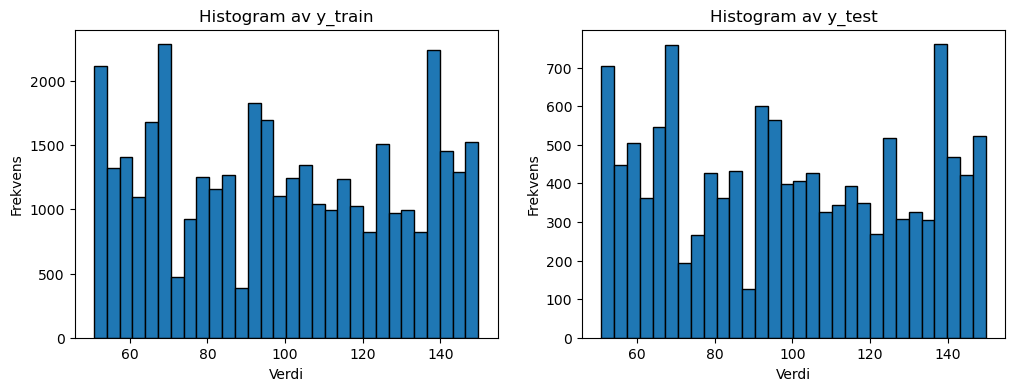

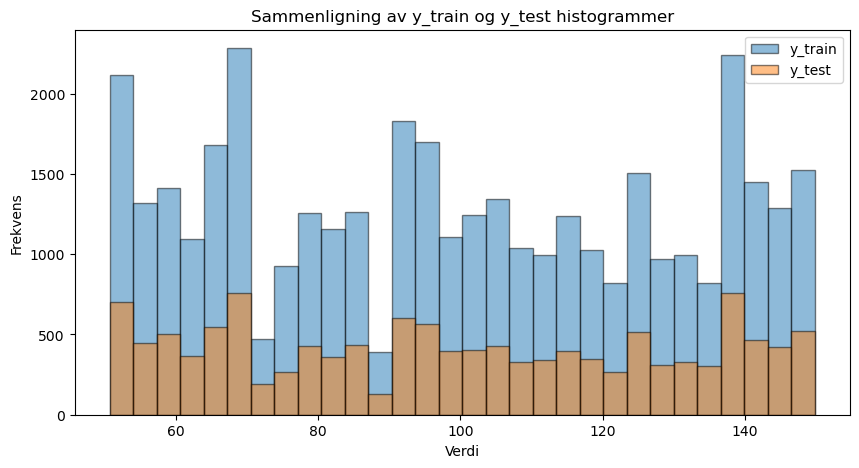

In [6]:
#TODO: visualiser y_train og y_test i et histogram

# Definerer ramme for y_train og y_test visualiseringer
plt.figure(figsize=(12, 4))

# Visualiser y_train
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='black')
plt.title("Histogram av y_train")
plt.xlabel("Verdi")
plt.ylabel("Frekvens")

# Visualiser y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, edgecolor='black')
plt.title("Histogram av y_test")
plt.xlabel("Verdi")
plt.ylabel("Frekvens")

# Viser plott
plt.show()

# Eget plott for å sammenligne y_train og y_test
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', edgecolor='black')
plt.hist(y_test, bins=30, alpha=0.5, label='y_test', edgecolor='black')
plt.title("Sammenligning av y_train og y_test histogrammer")
plt.xlabel("Verdi")
plt.ylabel("Frekvens")
plt.legend()
plt.show()

**Svar:**

Basert på histogrammet vi printet, ser vi at vi har en kontinuerlig fordeling av verdier for både y_train og y_test. Dette er typisk et regresjonsproblem. Verdiene er spredt utover et bredt spekter, hvor dersom vi heller hadde sett dem gruppere seg i klasser ville det vært mer sannsynlig at vi hadde sett på et klassifiseringsproblem. 

**Problemet er et regresjonsproblem.**

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [9]:
def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør kode

    # Beregner korrelasjonsmatrisen
    corr_matrix = X_temp.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title("korrelasjonsmatrise")
    plt.show()

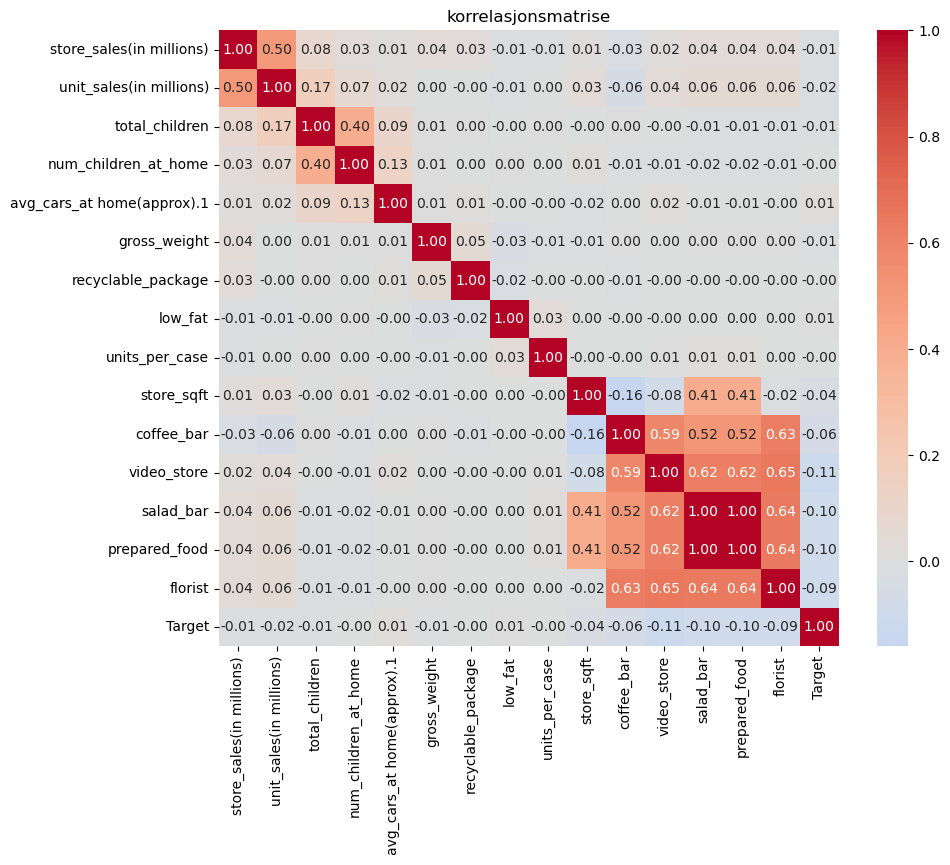

In [10]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**

Når vi skal identifisere variablene som har sterkest korrelasjon med Target, ser vi etter verdier som ligger så nærme +1 eller -1 som mulig (henholdsvis positiv og negativ korrelasjon). Ved å studere matrisen vår ser vi at det er ingen klare korrelasjoner med target da alle verdiene ligger veldig nærme null. De sterkeste korrelasjonene mot Target er allikevel:

**Største positive korrelasjoner**
- avg_cars_at_home(approx).1: 0.01
- low_fat: 0.01

**Største negative Korrelasjoner**
- video_store: -0.11
- salad_bar: -0.10
- prepared_food: -0.10

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [13]:
def hyperparameter_search(x, y):
    # Definer modellen
    model = RandomForestRegressor(random_state=42)
    
    # Definer hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200], # Antall trær modellen testes med
        'max_depth': [None, 10, 20], # Maks dypde for hvert tre
        'min_samples_split': [5, 10] # Minimum antall prøver for å dele hver node
    }
    
    # Definer Grid Search
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid, 
                               scoring='neg_mean_squared_error', 
                               cv=3, # Spesifiserer antall folds
                               n_jobs=-1, # Bruker alle tilgjengelige CPU kjerner
                               verbose=0)  # Sett verbose til 0 for å hindre standard utskrift
    
    # Kjører fit på grid search
    grid_search.fit(x, y)
    
    # Henter de beste parameterne og beste score
    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)  # Konverterer til positiv RMSE
    
    return best_params, best_score

In [14]:
# Utfør hyperparameter søk
best_params, best_score = hyperparameter_search(X_train, y_train)

print("Best parameters: ", best_params)
print("Best RMSE: ", round(best_score, 4))

Best parameters:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best RMSE:  29.1646


**Svar:**

#### Tolkning av beste parametere
**max_depth = 10:**
Modellen presterte best med en maksimal tre-dybde på 10, som gir indikasjon på at det er en god idè å begrense tredybden.

**min_samples_split = 10:**
Modellen ser ut til å favorisere færre delinger til fordel for mer robuste noder. Dette kan gi bedre generaliseringsevne ved å sikre at hver splitting er basert på et større antall prøver.

**n_estimators = 200:**
Høyere antall trær ga et bedre resultat sammenliknet med et lavere antall. Flere trør kan gi oss en mer stabil modell med mer nøyaktige resultater da det redusererer variansen i prediksjonene. 

#### Tolkning av RMSE

**Beste RMSE = 29.1646:**
Lavere verdi er bedre, og er en indikasjon på hvor godt modellen presterer. RMSE-tallet indikerer at modellen vil ha en gjennomsnittlig feil på rundt denne verdien i prediksjoner. Om dette er en god eller en dårlig RMSE avhenger mye av gjennomsnittet på målene våres. Dersom gjennomsnittet for målene er 100, vil en RMSE på 29 tilsvare 29% som ikke kjennetegner en veldig nøyaktig modell. Dersom gjennomsnittet er 1000 derimot vil RMSE på 29 tilsvare 2.9%.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [17]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

# Definerer optimal modell fra forrige oppgave
optimal_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=10, 
    random_state=42,
    n_jobs=-1
)

# Setter opp kryssvalidering
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lager scorere for MAE og MSE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Utfører kryssvalidering for begge metrikkene
mae_scores = cross_val_score(optimal_model, X_train, y_train, scoring=mae_scorer, cv=kf, n_jobs=-1)
mse_scores = cross_val_score(optimal_model, X_train, y_train, scoring=mse_scorer, cv=kf, n_jobs=-1)

# Printer resultater for hver runde
print("Mean Absolute Error (MAE) for hver runde:")
for i, score in enumerate(mae_scores, 1):
    print(f"Runde {i}: {-score:.2f}")

print("\nMean Squared Error (MSE) for hver runde:")
for i, score in enumerate(mse_scores, 1):
    print(f"Runde {i}: {-score:.2f}")

#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

# Beregner gjennomsnitt og standardavvik
mae_mean = -np.mean(mae_scores)
mae_std = np.std(mae_scores)
mse_mean = -np.mean(mse_scores)
mse_std = np.std(mse_scores)

# Beregner gjennomsnittlig faktisk pris og prosentvis feil
mean_y_train = np.mean(y_train)
average_error_percentage = (mae_mean / mean_y_train) * 100

# Printer resultatene
print("\nStatistikk for Mean Absolute Error (MAE):")
print(f"Gjennomsnitt: {mae_mean:.2f}")
print(f"Standardavvik: {mae_std:.2f}")

print("\nStatistikk for Mean Squared Error (MSE):")
print(f"Gjennomsnitt: {mse_mean:.2f}")
print(f"Standardavvik: {mse_std:.2f}")

print(f"\nGjennomsnittlig feil som prosent av gjennomsnittlig faktisk pris: {average_error_percentage:.2f}%")

Mean Absolute Error (MAE) for hver runde:
Runde 1: 25.19
Runde 2: 25.24
Runde 3: 25.10
Runde 4: 25.02
Runde 5: 24.91

Mean Squared Error (MSE) for hver runde:
Runde 1: 850.64
Runde 2: 855.68
Runde 3: 852.03
Runde 4: 850.79
Runde 5: 833.66

Statistikk for Mean Absolute Error (MAE):
Gjennomsnitt: 25.09
Standardavvik: 0.12

Statistikk for Mean Squared Error (MSE):
Gjennomsnitt: 848.56
Standardavvik: 7.67

Gjennomsnittlig feil som prosent av gjennomsnittlig faktisk pris: 25.26%


**Svar:**

#### Kommentar til resultatene

- Både MAE og MSE viser lave standardavvik (0.12 og 7.67) som indikerer at modellen er konsis i kryssvalideringen, og viser tegn på at den har en stabil ytelse.
- Modellens prediksjoner er off med 25.09 enheter i gjennomsnitt (MAE 25.09)
- Indikasjoner på noen større feil i prediksjonene med gjennomsnittlig MSE på 848.56
  - MSE straffer større feil mer enn mindre feil pga kvadrering
- Modellen viser en gjennomsnittlig feil på 25.26% av den gjennomsnittlige faktiske prisen.

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [20]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene


# Definerer optimal modell fra tidligere oppgaver
optimal_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=10, 
    random_state=42,
    n_jobs=-1
)

# Tren modellen på alle treningsdataene
optimal_model.fit(X_train, y_train)

# Gjør prediksjon på testdataene
y_pred = optimal_model.predict(X_test)

# Beregn Mean Absolute Error (MAE) på testdataene
mae_test = mean_absolute_error(y_test, y_pred)

# Beregn gjennomsnittlig faktisk pris i testdataene
mean_y_test = np.mean(y_test)

# Beregn gjennomsnittlig feil som prosentandel av gjennomsnittlig faktisk pris i testdataene
average_error_percentage_test = (mae_test / mean_y_test) * 100

mae_test, mean_y_test, average_error_percentage_test

(25.1288123781358, 99.30020325519818, 25.305902258382694)

**Svar:**

**Gjennomsnittlig feil (MAE):** 25.13

**Gjennomsnittlig faktisk pris i testdataene:** 99.30

**Gjennomsnittlig feil som prosentandel av gjennomsnittlig faktisk pris:** 25.31%

Resultatene med testdata ser ikke ut til å skille seg nevneverdig ut fra treningsdataene. Dette kan indikere at modellen har en god generaliseringsevne og ikke har overtilpasset seg treningsdataene. 